# Version 1.0 Model Predictions

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

## Import Data Sets
Here we will import `NetC_Expanded` which is data seperated by management style, result and slavage status, and we will import the predictors and join those datasets.

In [2]:
netc_expanded = pd.read_csv('../Data/NetC_Expanded.csv')
netc_expanded = netc_expanded.drop(['Unnamed: 0'], axis=1)
netc_expanded.head()

,TimeStep,Risk_Cat,Stand_ID,Salvage,Management,Result
0,0,4,0023200606030102900043,True,Heavy,-249.287884
1,0,4,0023200606030102900043,True,NoMgmt,-321.931519
2,0,4,0023200606030102900043,True,Moderate,-276.111511
3,0,4,0023200606030102900043,True,Comm-Ind,-250.583375
4,0,4,0023200606030102900043,True,HighGrade,-293.426896


In [3]:
predictors = pd.read_csv('../Data/Predict_SBW_wCarbon_T0to40.csv')
predictors = predictors.rename(columns={'StandID': 'Stand_ID'})
predictors = predictors.set_index('Stand_ID')
predictors = predictors[["BF_BA","OHost_BA","BF_Stock","OHost_Stock","NonHost_Stock","BF_QMD","ELEV","SLOPE","ASPECT","LAT","SiteInd"]]
predictors.head()

,BF_BA,OHost_BA,BF_Stock,OHost_Stock,NonHost_Stock,BF_QMD,ELEV,SLOPE,ASPECT,LAT,SiteInd
Stand_ID,,,,,,,,,,,
0023200606030200300067,NaN,0.498332,NaN,0.883600,56.9255,NaN,580,5.0,240.0,46.14358,NaN
0023200606030200300826,3.899610,11.890484,21.8437,0.885569,18.6635,4.965398,1170,0.0,0.0,47.19684,28.0
0023200606030200300924,0.036869,7.443510,0.2679,1.166825,3.8019,2.600000,990,0.0,0.0,46.64171,33.0
0023200606030301901813,0.967649,1.368845,63.7216,1.609179,12.1858,2.106063,180,0.0,0.0,45.09319,40.0
0023200606030400901513,3.352901,6.679677,73.4189,1.397641,18.2434,3.405766,250,0.0,0.0,44.73563,NaN


## Selecting Management Style 
Gong to define a management style upfront to create rule set

In [819]:
MANAGEMENT_STYLE = 'NoMgmt'

# mgmt_df = netc_expanded[netc_expanded['Management'] == MANAGEMENT_STYLE]

### Apply Discount Rate
Didn't have time to make a "smart" implimentation of this. 

In [820]:
def discount(df):
    ## Initialize df
    temp_df = df.copy()
    temp_df = temp_df.sort_values(by=['Stand_ID', 'TimeStep'])
    
    ## Define discount rate
    discount_rate = lambda diff, t: diff * (1 / (1 + 0.02) ** t)
    for i, row in temp_df.iterrows():
        
        ## If first timestep do nothing
        if row['TimeStep'] == 0:
            continue
            
        diff = row['Result'] - temp_df.loc[(temp_df['TimeStep'] == (row['TimeStep'] - 10)) 
                                           & (temp_df['Salvage'] == row['Salvage']) &
                                           (temp_df['Stand_ID'] == row['Stand_ID']), 'Result'].values[0]
        
        base = temp_df.loc[(temp_df['TimeStep'] == 0) & 
                   (temp_df['Salvage'] == row['Salvage']) &
                   (temp_df['Stand_ID'] == row['Stand_ID']), 'Result'].values[0]
    
        discounted_result = discount_rate(diff, row['TimeStep']) + base
        
        ## update df
        temp_df.at[i, 'Result'] = discounted_result 
        
        
    return temp_df

In [821]:
discount_df = discount(mgmt_df)

In [822]:
def get_mgmt_df(target_df, pred_df, tol):
    """
    Returns labeled DF for salvage and non salvage decisions
    """
    temp_df = pd.DataFrame(columns=['Stand_ID', 'Give_Voucher', 'Result'])
    for stand in target_df['Stand_ID'].unique():
        
        group_df = target_df[(target_df['Stand_ID'] == stand)
                             & (target_df['TimeStep'] == 40)]
        group_df = group_df.set_index('Salvage')
        
        assert group_df.shape[0] == 2
        
        # calculate diff
        diff =  group_df.at[True, 'Result'] - group_df.at[False, 'Result']
        
        #  If index is True where min is acheived
        if group_df['Result'].idxmin():  # and diff > tol:
            temp_df = temp_df.append(
                pd.DataFrame({
                    'Stand_ID': [stand],
                    'Give_Voucher': [0],
                    'Result': [group_df['Result'].min()],
                    'diff': [diff]
                })
            )
        else:
            temp_df = temp_df.append(
                pd.DataFrame({
                    'Stand_ID': [stand],
                    'Give_Voucher': [1],
                    'Result': [group_df['Result'].min()],
                    'diff': [diff]
                })
            )
            
    temp_df = temp_df.set_index('Stand_ID')
    return pd.merge(pred_df, temp_df, on="Stand_ID", right_index=True)

In [823]:
heavy_df = get_mgmt_df(discount_df, predictors, 0)
heavy_df = heavy_df.fillna(heavy_df.median())
# heavy_df[heavy_df['Give_Voucher'] == True].assign(percent_improvement=heavy_df['diff'] / (heavy_df['Result'] - heavy_df['diff'])).describe()
heavy_df.head()

,BF_BA,OHost_BA,BF_Stock,OHost_Stock,NonHost_Stock,BF_QMD,ELEV,SLOPE,ASPECT,LAT,SiteInd,Give_Voucher,Result,diff
Stand_ID,,,,,,,,,,,,,,
0023200606030200300067,2.325367,0.498332,11.4585,0.883600,56.9255,5.490730,580,5.0,240.0,46.14358,42.0,1,-424.433210,16.989457
0023200606030200300826,3.899610,11.890484,21.8437,0.885569,18.6635,4.965398,1170,0.0,0.0,47.19684,28.0,1,-432.105486,58.165202
0023200606030200300924,0.036869,7.443510,0.2679,1.166825,3.8019,2.600000,990,0.0,0.0,46.64171,33.0,1,-336.976590,18.965326
0023200606030301901813,0.967649,1.368845,63.7216,1.609179,12.1858,2.106063,180,0.0,0.0,45.09319,40.0,0,-438.233906,-37.347023
0023200606030400901513,3.352901,6.679677,73.4189,1.397641,18.2434,3.405766,250,0.0,0.0,44.73563,42.0,1,-393.888667,35.211018


### How much is saved on average when a voucher is given normally? 

In [842]:
heavy_df['Give_Voucher'].value_counts()

1    2830
0    2096
Name: Give_Voucher, dtype: int64

In [824]:
heavy_df[heavy_df['diff'] > 0]['diff'].describe()

count    2830.000000
mean       32.522794
std        38.508204
min         0.004595
25%         9.271640
50%        21.722638
75%        42.152624
max       390.485405
Name: diff, dtype: float64

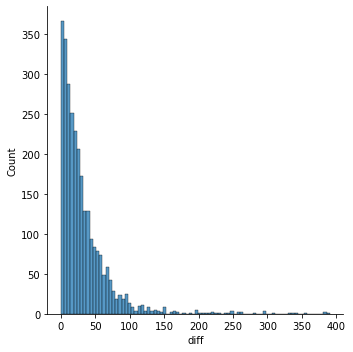

In [825]:
sns.displot(heavy_df[heavy_df['diff'] > 0]['diff'])

## Split Data

In [826]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [827]:
X = heavy_df.drop(['Give_Voucher', 'Result'], axis=1)
y = heavy_df[['Give_Voucher']].astype('int')

In [828]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

## Baselines

`IP` is an interpretability constant since net saved emissions is always large

In [829]:
IP = 10000

In [840]:
assess_df = mgmt_df.set_index('Stand_ID')
assess_df = assess_df[assess_df['TimeStep'] == 40]
assess_df = assess_df[['Salvage', 'Result']]

assess_df = pd.merge(assess_df, X_test, on="Stand_ID")

### (1) Don't Salvage At All

In [831]:
no_salvage = assess_df[(assess_df['Salvage'] == False)]
no_salvage_score = no_salvage['Result'].sum()
no_salvage_score / IP

-61.49652670148

### (2) Only Salvage

In [832]:
only_salvage = assess_df[(assess_df['Salvage'] == True)]
only_salvage_score = only_salvage['Result'].sum()
only_salvage_score / IP

-67.18429340769

### (3) Optimal

In [833]:
(assess_df
 .reset_index('Stand_ID')
 .groupby('Stand_ID')
 .agg({'Result': np.min})
 .Result.sum()) / IP

-67.42109368653

In [843]:
assess_df

,Salvage,Result,BF_BA,OHost_BA,BF_Stock,OHost_Stock,NonHost_Stock,BF_QMD,ELEV,SLOPE,ASPECT,LAT,SiteInd
Stand_ID,,,,,,,,,,,,,
0023200606030102900318,True,-739.253578,0.469044,2.327331,14.4849,1.529948,36.1694,2.318405,270,0.0,0.0,45.142910,39.0
0023200606030102900318,False,-676.760218,0.469044,2.327331,14.4849,1.529948,36.1694,2.318405,270,0.0,0.0,45.142910,39.0
0023200606030102900364,True,-563.582414,0.436265,1.493851,11.7051,2.402306,33.2408,2.828250,200,0.0,0.0,44.806430,42.0
0023200606030102900364,False,-475.711339,0.436265,1.493851,11.7051,2.402306,33.2408,2.828250,200,0.0,0.0,44.806430,42.0
0023200606030102900403,True,-755.175482,0.771468,3.802583,0.9249,0.617915,44.7805,3.964425,110,0.0,0.0,44.899650,42.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
0050201508030300102521,False,-179.639224,16.671242,22.398651,55.0399,1.051561,2.2306,6.754435,3750,33.0,315.0,44.121913,24.0
0050201508030300300668,True,-691.197505,2.325367,6.568634,11.4585,1.462414,51.2781,5.490730,2230,13.0,222.0,42.903534,54.0
0050201508030300300668,False,-710.131383,2.325367,6.568634,11.4585,1.462414,51.2781,5.490730,2230,13.0,222.0,42.903534,54.0


### SKOPE Rules

In [834]:
from imodels import SkopeRulesClassifier
from imodels import BayesianRuleListClassifier
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt

In [835]:
try:
    X_train = X_train.drop(['diff'], axis=1)
    X_test = X_test.drop(['diff'], axis=1)
except KeyError:
    pass

In [836]:
clf = SkopeRulesClassifier(
    max_depth_duplication=1000,
    n_estimators=90,
    precision_min=0.7,
    recall_min=0.01
)
clf.fit(X_train, y_train.to_numpy().ravel())

SkopeRulesClassifier(max_depth_duplication=1000, n_estimators=90,
                     precision_min=0.7)

In [837]:
y_train_pred = clf.predict_top_rules(X_train, 10)
accuracy_score(y_train, y_train_pred)

0.7261421319796955

In [838]:
y_pred = clf.predict_top_rules(X_test, 10)
accuracy_score(y_test, y_pred)

0.7261663286004056

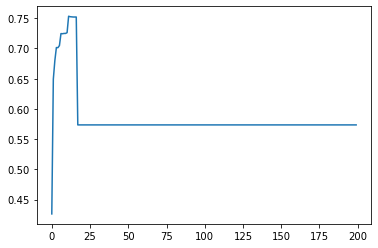

In [839]:
def show_rules():
    """ 
    plot rules over time
    """
    preds = [accuracy_score(y_train, clf.predict_top_rules(X_train, i)) for i in range(200)]
    plt.plot([i for i in range(len(preds))],  preds)

show_rules()

In [812]:
for rule in clf.rules_:
    print(rule)

('feature_1 > 5.665860652923584 and feature_10 <= 44.25 and feature_5 > 4.512676477432251', (0.7783018867924528, 0.3733031674208145, 1))
('feature_1 > 5.854950904846191 and feature_10 <= 41.75', (0.76, 0.3510392609699769, 1))
('feature_0 > 3.001827120780945 and feature_1 > 5.665860652923584 and feature_10 <= 45.5', (0.80625, 0.2986111111111111, 1))
('feature_1 > 5.8917927742004395 and feature_10 <= 44.25 and feature_2 > 6.599850177764893', (0.7411764705882353, 0.3, 1))
('feature_1 > 5.725090980529785 and feature_10 <= 48.5 and feature_2 <= 11.4788498878479', (0.7183098591549296, 0.23076923076923078, 1))
('feature_0 <= 3.8348982334136963 and feature_1 > 5.665860652923584 and feature_10 <= 45.5', (0.7246376811594203, 0.22935779816513763, 1))
('feature_1 > 5.733026504516602 and feature_10 <= 37.25 and feature_3 <= 2.4614005088806152', (0.8189655172413793, 0.21839080459770116, 1))
('feature_1 > 5.895092248916626 and feature_10 > 37.25 and feature_2 > 14.43304967880249', (0.7217391304347827

In [813]:
def print_columns(X, cols):
    print("RULES LEARNED: ")
    for col in cols:
        print("feature_{} is {}".format(col, X_train.columns[col]))
        
        
print_columns(X_test, [2, 3, 4, 5, 6, 9])

RULES LEARNED: 
feature_2 is BF_Stock
feature_3 is OHost_Stock
feature_4 is NonHost_Stock
feature_5 is BF_QMD
feature_6 is ELEV
feature_9 is LAT


In [814]:
np.unique(y_pred, return_counts=True)

(array([0, 1]), array([485, 501]))

### (4) Skope Rules (assess savings)

In [698]:
from sklearn.metrics import precision_score, recall_score

In [815]:
def assess_savings(X_test, y_pred):
    """
    Append predicitons and sum slavage/no salvage results 
    """
    # add predictions
    test_df = X_test.copy()
    test_df['preds'] = y_pred

    # merge with management 
    temp = pd.merge(assess_df, test_df, on="Stand_ID")

    salvage_sum = temp[(temp['Salvage'] == True) & (temp['preds'] == 1)].Result.sum()
    no_salvage_sum = temp[(temp['Salvage'] == False) & (temp['preds'] == 0)].Result.sum()

    return salvage_sum + no_salvage_sum

In [816]:
skope_rules_score = assess_savings(X_test, y_pred)
skope_rules_score / IP

-63.780382574700006

---

In [704]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import _tree

clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.5172413793103449

In [705]:
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier

In [706]:
clf = AdaBoostClassifier()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
accuracy_score(y_test, y_pred)

/home/sean/anaconda3/envs/optimization/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


0.5892494929006086

In [707]:
clf = RandomForestClassifier()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
accuracy_score(y_test, y_pred)

/home/sean/anaconda3/envs/optimization/lib/python3.7/site-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


0.6105476673427992